# 인공지능개론 과제2

소프트웨어학과 2019311218 이진우 

# 1. Data Preprocess
다운 받은 'ChestXRay2017.zip'을 학습을 편하게 하기 위해 pickle(*.pkl) 파일로 변환해줍니다. 

사진 채널은 RGB, 크기는 256x256으로 설정해줍니다. 

또한, 지도 학습을 위해 라벨을 설정해줍니다. (정상 = 0, 박테리아성 = 1, 바이러스성 = 2)

## 1-1. Train set 준비

In [3]:
import os
import pandas as pd
import numpy as np
from PIL import Image

path_dir = 'E:/data/train/'
folder_list = os.listdir(path_dir)

train_set = pd.DataFrame(columns=['image', 'label'])

for folder in folder_list:
    file_list = os.listdir(path_dir + folder)
    for file_name in file_list:
        image = Image.open('{}/{}'.format(path_dir + folder, file_name)).convert('RGB').resize((256, 256), resample=Image.NEAREST)
        image = np.array(image, 'uint8')
        label = 1 if 'bacteria' in file_name else (2 if 'virus' in file_name else 0)

        train_set = train_set.append({'image' : image, 'label' : label}, ignore_index=True)

만들어진 Train set의 라벨별 데이터 수를 확인합니다.

In [6]:
train_set.label.value_counts()

1    2538
0    1349
2    1345
Name: label, dtype: int64

In [4]:
train_set.to_pickle('./train.pkl')

## 1-2. Test set 준비

In [7]:
path_dir = 'E:/data/test/'
folder_list = os.listdir(path_dir)

test_set = pd.DataFrame(columns=['image', 'label'])

for folder in folder_list:
    file_list = os.listdir(path_dir + folder)
    for file_name in file_list:
        image = Image.open('{}/{}'.format(path_dir + folder, file_name)).convert('RGB').resize((256, 256), resample=Image.NEAREST)
        image = np.array(image, 'uint8')
        label = 1 if 'bacteria' in file_name else (2 if 'virus' in file_name else 0)

        test_set = test_set.append({'image' : image, 'label' : label}, ignore_index=True)

만들어진 Test set의 라벨별 데이터 수를 확인합니다.

In [8]:
test_set.label.value_counts()

1    242
0    234
2    148
Name: label, dtype: int64

In [9]:
test_set.to_pickle('./test.pkl')

내보낸 데이터 확인

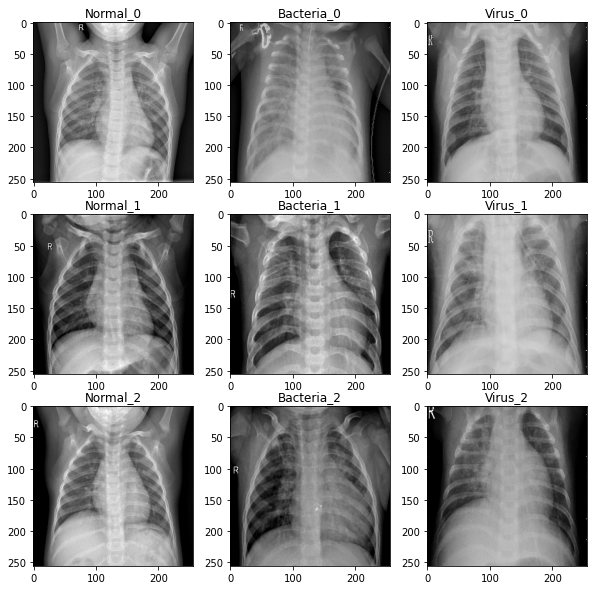

In [14]:
import matplotlib.pyplot as plt

train_set = pd.read_pickle('./train.pkl')
title = ['Normal', 'Bacteria', 'Virus']

f, ax = plt.subplots(3, 3, figsize=(10, 10))

for label in train_set.label.unique():
    df = train_set[train_set.label == label].reset_index(drop=True)
    for i in range(3):
        ax[i][label].imshow(df.image[i])
        ax[i][label].set_title('{}_{}'.format(title[label], i))

plt.show()

# 2. Data Augmentation

현재 Train set은 아래와 같이 라벨 별로 데이터의 수가 차이가 있습니다. (약 1 : 2 : 1)

그렇게 큰 차이는 아니지만 라벨 1에 치우친 결과가 나올 수 있으므로 라벨별 데이터의 양을 같게 만들어줍니다.

In [2]:
train_set = pd.read_pickle('./train.pkl')
train_set.label.value_counts()

1    2538
0    1349
2    1345
Name: label, dtype: int64

기존의 Train set에서 라벨별로 1500개를 추출해 Train : Validation = 7 : 3으로 분리한 다음, 

Train set을 좌우 반전시켜 데이터의 양을 2배로 늘립니다. 

이 과정을 거치면 Train : Validation : Test = 약 7 : 2 : 1이 됩니다.

In [18]:
import cv2

target_size = 1500
test_split = 0.3
split_index = int(target_size * (1 - test_split))

train = pd.DataFrame(columns=['image', 'label'])
val = pd.DataFrame(columns=['image', 'label'])

for label in train_set.label.unique():
    df = train_set[train_set.label == label]
    df = df.sample(target_size, replace=(df.shape[0] < target_size), random_state=42).reset_index(drop=True)
    
    train_ = df.loc[:split_index, :]
    val_ = df.loc[split_index:, :]

    train = pd.concat([train, train_], ignore_index=True)
    train.image = train.image.apply(cv2.flip, args=(1, ))

    train = pd.concat([train, train_], ignore_index=True)
    val = pd.concat([val, val_], ignore_index=True)

새로 만들어진 Train set, Validation set의 라벨별 데이터 수를 확인합니다.

In [19]:
train.label.value_counts(), val.label.value_counts()

(2    2102
 1    2102
 0    2102
 Name: label, dtype: int64,
 2    450
 1    450
 0    450
 Name: label, dtype: int64)

In [20]:
train.to_pickle('./train_new.pkl')
val.to_pickle('./val.pkl')

# 3. Machine Learning

준비된 데이터셋과 머신러닝 알고리즘을 활용하여 

주어진 입력을 3가지의 라벨로 분류하는 Classifier를 만듭니다.

## 3-1. Soft Voting Ensemble Model

여러 머신러닝 알고리즘의 결과를 종합해 결과를 도출하는 Voting Classifier를 시도했습니다.

각 알고리즘의 분류 결과만을 합치는 Hard Voting과 

각 알고리즘의 확률값을 합치는 Soft Voting 중 Soft Voting을 사용했습니다.

### 3-1-1. Feature Extraction

CNN과 같이 Feature Extraction이 필요하지 않은 알고리즘 외에는

주어진 입력(이미지)를 머신러닝 학습에 그대로 사용할 수 없습니다.

따라서 이미지에서 특성(Feature)를 추출해 이를 학습 데이터로 사용합니다.

Cross Validation을 진행할 것이므로 위에서 나누기 전의 Train, Test를 하나로 합쳐줍니다.

In [29]:
train_set = pd.read_pickle('./train.pkl')
test_set = pd.read_pickle('./test.pkl')
df = pd.concat([train_set, test_set], ignore_index=True)

각 Label 별로 1500개의 Data를 추출합니다.

In [33]:
new_df = pd.DataFrame(columns=df.columns)

for i in range(3):
    temp = df[df.label == i]
    temp = temp.sample(1500, replace=(temp.shape[0] < 1500), random_state=42)
    new_df = pd.concat([new_df, temp], axis=0)

In [34]:
new_df.label.value_counts()

2    1500
1    1500
0    1500
Name: label, dtype: int64

Fully Connected Layer를 제외하고 Conv와 Pool Layer만 있는 

CNN을 Feature Extractor로 사용한 논문을 보고 이를 시도해봤습니다.

Feature Extractor로 사용한 CNN은 ImageNet으로 Train된 ResNet50 모델입니다.

In [24]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
model

Using cache found in C:\Users\Jinu/.cache\torch\hub\pytorch_vision_v0.6.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

마지막에 있는 Fully Connected Layer를 제거해줍니다.

In [26]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

model.fc = Identity()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

ResNet50의 Conv, Pool Layer를 통해 2048개의 Feature를 추출합니다.

ImageDataSet은 아래의 3-2-2에 정의되어 있습니다.

In [39]:
test_set = ImageDataSet(new_df.image, new_df.label, train=False)
test_sampler = SequentialSampler(test_set)
test_loader = DataLoader(test_set, batch_size=1, sampler=test_sampler)

extracted = pd.DataFrame()

model = model.to(device)
model.eval()

with torch.no_grad():
    for data, label in test_loader:
        data = data.to(device)
        output = model(data)
        image = output.cpu().numpy()[0]

        extracted = extracted.append(pd.Series(dict(zip(range(2048), image))), ignore_index=True)

In [40]:
extracted

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.253976,0.138978,1.139892,0.049757,0.278259,1.150975,0.186683,0.056085,1.109566,0.608029,...,0.717251,0.004655,0.047935,0.375460,0.359101,0.107250,0.099624,0.196901,1.958830,1.861120
1,1.173394,0.150542,0.682269,0.084369,0.764591,2.269954,0.431198,0.011467,2.157981,0.709124,...,0.596217,0.000000,0.296491,0.273012,0.486185,0.172281,0.181925,0.399408,2.841907,2.072515
2,0.293751,0.613813,1.312519,0.157973,0.400389,1.417417,0.168992,0.152289,0.821151,0.418723,...,0.403715,0.065505,0.109660,0.078679,0.778056,0.117322,0.189048,0.216071,1.734568,1.767086
3,1.011682,0.149283,0.691831,0.048901,0.504667,2.207746,0.382125,0.008638,1.005487,0.472336,...,0.751124,0.005812,0.319797,0.371949,0.465796,0.075821,0.294187,0.278283,3.349099,1.676977
4,0.955060,0.318847,0.796219,0.246794,0.728333,2.526213,0.288273,0.136372,1.090939,0.659840,...,0.399403,0.004559,0.513740,0.401552,0.682065,0.128925,0.236480,0.263388,1.971574,2.142498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,1.022305,0.641169,1.069502,0.208222,0.703385,2.320043,0.233170,0.266027,0.388148,0.504608,...,0.255815,0.003636,0.094868,0.422715,0.519079,0.242129,0.082751,0.160269,1.848379,1.881976
4496,0.114594,0.308110,0.436993,0.060108,0.223127,0.989074,0.355052,0.091222,1.493288,0.357912,...,0.453192,0.065156,0.034523,0.286951,0.112921,0.185003,0.008635,0.109003,2.102103,1.041822
4497,0.924701,0.137414,0.420186,0.077658,0.555286,3.348397,0.248592,0.468739,0.932906,0.643924,...,0.576183,0.094349,0.500179,0.165178,0.424927,0.107493,0.029598,0.204829,2.605117,1.355376
4498,0.235376,0.166322,1.346018,0.025158,0.039127,0.571925,0.518264,0.779906,1.100405,0.533119,...,0.323552,0.036309,0.044094,0.143529,0.391048,0.248103,0.148703,0.108597,1.551902,0.773926


### 3-1-2. Scaling

데이터의 값이 너무 클 경우 학습이 오래 걸릴 수 있습니다.

따라서 학습 전에 스케일링 작업이 필요합니다.

Outlier의 영향을 줄여주는 RobustScaler를 사용합니다.

In [41]:
from sklearn.preprocessing import RobustScaler

X = extracted.values
y = new_df.label.values.astype('int')

scaler = RobustScaler()
X = scaler.fit_transform(X)

### 3-1-3. Classifier

총 5개의 머신러닝 알고리즘의 결과를 Ensemble하여 결과를 도출합니다.

사용하는 알고리즘은 LR(Logistic Regression), SVM(Support Vector Machine),

RF(Random Forest), GBM(Gradient Boosting Machine), ANN(Artificial Neural Network)입니다.

각각의 Hyperparameter는 Grid Search와 Random Search를 사용해 Tuning 했습니다.

In [42]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

clf1 = LogisticRegression(C=2**-4, solver='liblinear', max_iter=500, random_state=42)
clf2 = SVC(C=2**-5, kernel='linear', probability=True, random_state=42)
clf3 = RandomForestClassifier(n_estimators=500, random_state=42)
clf4 = XGBClassifier(n_estimators=500, learning_rate=0.2, subsample=0.8, max_depth=8, min_child_weight=5, objective="multi:softprob", num_class=3)
clf5 = MLPClassifier(hidden_layer_sizes=(100, 100), alpha=0.001, max_iter=500, early_stopping=True, random_state=42)

models = zip(('LR', 'SVM', 'RF', 'GBM', 'ANN'), (clf1, clf2, clf3, clf4, clf5))
model = VotingClassifier(list(models), voting="soft")

### 3-1-4. Cross Validation

Voting Classifier의 성능을 평가하기 위해 Cross Validation을 수행합니다.

Train : Test의 비율은 위에서 나눈 비율과 비슷하게 9 : 1로 진행했습니다.

In [44]:
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate

cv = StratifiedShuffleSplit(n_splits=10, random_state=42)
scoring = ["accuracy", "precision_micro", "recall_micro", "f1_micro", "roc_auc_ovr"]

score = cross_validate(model, X, y, scoring=scoring, cv=cv, n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 16.9min remaining: 39.5min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 16.9min remaining: 16.9min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 17.0min remaining:  7.3min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 17.5min finished


Cross Validation의 결과를 확인합니다. 약 87.49%의 정확도가 나왔습니다.

In [45]:
pd.DataFrame(score).mean()

fit_time                996.131945
score_time                4.483487
test_accuracy             0.874889
test_precision_micro      0.874889
test_recall_micro         0.874889
test_f1_micro             0.874889
test_roc_auc_ovr          0.962697
dtype: float64

## 3-2. Convolutional Neural Network

90% 이상의 정확도를 얻기 위해 CNN 모델도 시도해봤습니다.

위에서 Feature Extractor로 사용한 ResNet50을 사용하려했으나, 학습 시간 등을 고려하여 ResNet18로 대체했습니다.

### 3-2-1. Library

Pytorch 라이브러리를 활용합니다.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchsummary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

Random Seed와 Batch Size를 설정해줍니다.

In [4]:
torch.manual_seed(42)
np.random.seed(42)

batch_size = 50

GPU를 사용할 수 있게 설정해줍니다.

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

### 3-2-2. Dataset

학습을 하기 위해서는 Dataset이 필요합니다.

Data Augmentation을 활용하기 위해 Custom Dataset을 만들어줍니다.

Data Augmentation은 Rotation, Shift, Zoom을 활용합니다.

Flip은 위에서 Data Imbalance를 해결하기 위해 사용했기 때문에 제외합니다.

In [35]:
class ImageDataSet(Dataset):
    def __init__(self, X, y, train=False):
        self.X = X.reset_index(drop=True)
        self.y = y.reset_index(drop=True)
        self.train = train

        self.train_transform = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(size=(224, 224)),
                transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.9, 1.1)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]
        )
        self.val_transform = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(size=(224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]
        )

    def __len__(self):
        return self.y.size

    def __getitem__(self, idx):
        image, label = self.X[idx], self.y[idx]
        
        if self.train:
            image = self.train_transform(image)
        else:
            image = self.val_transform(image)

        return image, label

학습을 위해 위에서 만든 Dataset으로 DataLoader를 만들어줍니다.

In [6]:
train = pd.read_pickle('./train_new.pkl')
val = pd.read_pickle('./val.pkl')

train_set = ImageDataSet(train.image, train.label, train=True)
train_sampler = RandomSampler(train_set)
train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler)

val_set = ImageDataSet(val.image, val.label, train=False)
val_sampler = RandomSampler(val_set)
val_loader = DataLoader(val_set, batch_size=batch_size, sampler=val_sampler)

### 3-2-3. Model (ResNet18)

ResNet18의 Layer를 쌓아줍니다.

Pytorch에 구현된 모델의 Layer와 다른 자료를 참고해 구현했습니다.

먼저 구현된 모델의 Layer를 확인합니다.

In [29]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', num_classes=3).to(device)

torchsummary.summary(model, (3, 224, 224), batch_size=batch_size, device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [50, 64, 112, 112]           9,408
       BatchNorm2d-2         [50, 64, 112, 112]             128
              ReLU-3         [50, 64, 112, 112]               0
         MaxPool2d-4           [50, 64, 56, 56]               0
            Conv2d-5           [50, 64, 56, 56]          36,864
       BatchNorm2d-6           [50, 64, 56, 56]             128
              ReLU-7           [50, 64, 56, 56]               0
            Conv2d-8           [50, 64, 56, 56]          36,864
       BatchNorm2d-9           [50, 64, 56, 56]             128
             ReLU-10           [50, 64, 56, 56]               0
       BasicBlock-11           [50, 64, 56, 56]               0
           Conv2d-12           [50, 64, 56, 56]          36,864
      BatchNorm2d-13           [50, 64, 56, 56]             128
             ReLU-14           [50, 64,

ResNet 모델의 구현을 위한 레이어들입니다.

In [7]:
class Shortcut(nn.Module):
    def __init__(self, in_channels, out_channels, expansion, stride):
        super(Shortcut, self).__init__()

        self.layer = nn.Sequential()
        if stride != 1 or in_channels != expansion * out_channels:
            self.layer.add_module('conv1', nn.Conv2d(in_channels, expansion * out_channels, kernel_size=1, stride=stride, bias=False))
            self.layer.add_module('bn1', nn.BatchNorm2d(expansion * out_channels))

    def forward(self, x):
        return self.layer(x)

class Block(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(Block, self).__init__()

        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.shortcut = Shortcut(in_channels, out_channels, self.expansion, stride)

    def forward(self, x):
        out = self.layer(x)
        out += self.shortcut(x)

        return F.relu(out)

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=3, extract=False):
        super(ResNet, self).__init__()
        self.extract = extract

        in_channels = 64
        out_channels = 64
        strides = [1, 2, 2, 2]

        layers = []
        for i in range(4):
            for stride in [strides[i]] + [1] * (num_blocks[i] - 1):
                layers.append(block(in_channels, out_channels, stride))
                in_channels = out_channels * block.expansion
            out_channels = out_channels * 2

        self.layer = nn.Sequential(*layers)

        self.init = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.init(x)
        x = self.layer(x)

        if self.extract:
            x = x.view(x.size(0), -1)
        else:
            x = self.pool(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)

        return x

def ResNet18(num_classes=3):
    return ResNet(Block, [2, 2, 2, 2], num_classes=num_classes)

만들어진 모델의 Layer도 확인합니다.

In [32]:
model = ResNet18(num_classes=3).to(device)

torchsummary.summary(model, (3, 224, 224), batch_size=batch_size, device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [50, 64, 112, 112]           9,408
       BatchNorm2d-2         [50, 64, 112, 112]             128
              ReLU-3         [50, 64, 112, 112]               0
         MaxPool2d-4           [50, 64, 56, 56]               0
            Conv2d-5           [50, 64, 56, 56]          36,864
       BatchNorm2d-6           [50, 64, 56, 56]             128
              ReLU-7           [50, 64, 56, 56]               0
            Conv2d-8           [50, 64, 56, 56]          36,864
       BatchNorm2d-9           [50, 64, 56, 56]             128
         Shortcut-10           [50, 64, 56, 56]               0
            Block-11           [50, 64, 56, 56]               0
           Conv2d-12           [50, 64, 56, 56]          36,864
      BatchNorm2d-13           [50, 64, 56, 56]             128
             ReLU-14           [50, 64,

### 3-2-4. Loss Function & Optimizer

학습에 중요한 요소인 Loss Function과 Optimizer를 설정해줍니다.

Loss Function으로는 CrossEntropyLoss를 사용합니다.

In [9]:
loss_function = nn.CrossEntropyLoss()

Optimizer는 SGD (Stochastic Gradient Descent)를 사용합니다.

Learning Rate를 조절해줄 Scheduler도 사용합니다.

Bad Epoch(= Val Loss가 줄어들지 않음)이 8번(= patience + 1) 발생하면 

Learning Rate에 factor(= 0.1)를 곱해줍니다.

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=7, verbose=True)

### 3-2-5. Train

위에서 만든 ResNet18 모델을 학습시키기 위한 함수를 만듭니다.

In [11]:
def train():
    model.train()

    train_loss = 0
    num_correct = 0
    total_guesses = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        output = model(data)
        loss = loss_function(output, target.long())
        loss.backward()
        train_loss += loss.item()

        optimizer.step()

        predict = torch.argmax(output, 1)
        num_correct += torch.eq(target, predict).sum().item()
        total_guesses += batch_size

    train_loss /= len(train_loader)
    accuracy = 100 * num_correct / total_guesses

    train_losses.append(train_loss)
    train_accuracy.append(accuracy)

    return train_loss, accuracy

def evaluate():
    model.eval()

    test_loss = 0
    num_correct = 0
    total_guesses = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)

            test_loss += loss_function(output, target.long()).item()

            predict = torch.argmax(output, 1)
            num_correct += torch.eq(target, predict).sum().item()
            total_guesses += batch_size

    test_loss /= len(val_loader)
    accuracy = 100 * num_correct / total_guesses

    test_losses.append(test_loss)
    test_accuracy.append(accuracy)
    
    return test_loss, accuracy

학습할 Epoch 수를 설정합니다.

학습 과정 중의 Loss와 Accuracy를 저장할 리스트도 만듭니다. 

In [12]:
num_epochs = 50

train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

정해진 Epoch 만큼 모델을 학습시킵니다.

Validation Loss가 가장 낮을 때의 모델의 Parameter를 저장해줍니다. 

In [13]:
best_loss = 1000

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train()
    test_loss, test_acc = evaluate()

    print('[{} / {}]\tTrain loss: {:.4f}\tTrain Accuracy: {:.4f}%\tTest loss: {:.4f}\tTest Accuracy: {:.4f}%'.format(epoch, num_epochs, train_loss, train_acc, test_loss, test_acc))
    
    scheduler.step(test_loss)

    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), './best.pt')

[1 / 50]	Train loss: 0.7841	Train Accuracy: 60.9921%	Test loss: 0.9959	Test Accuracy: 54.6667%
[2 / 50]	Train loss: 0.6538	Train Accuracy: 66.6299%	Test loss: 0.6401	Test Accuracy: 72.8889%
[3 / 50]	Train loss: 0.5903	Train Accuracy: 71.1181%	Test loss: 0.9897	Test Accuracy: 60.0741%
[4 / 50]	Train loss: 0.5725	Train Accuracy: 72.0630%	Test loss: 0.6668	Test Accuracy: 70.4444%
[5 / 50]	Train loss: 0.5427	Train Accuracy: 74.3150%	Test loss: 2.2631	Test Accuracy: 52.5926%
[6 / 50]	Train loss: 0.5236	Train Accuracy: 75.2126%	Test loss: 0.5411	Test Accuracy: 76.5926%
[7 / 50]	Train loss: 0.5138	Train Accuracy: 76.1890%	Test loss: 0.7992	Test Accuracy: 69.7037%
[8 / 50]	Train loss: 0.5113	Train Accuracy: 76.8189%	Test loss: 1.6984	Test Accuracy: 59.1852%
[9 / 50]	Train loss: 0.4956	Train Accuracy: 77.3071%	Test loss: 0.8062	Test Accuracy: 69.8519%
[10 / 50]	Train loss: 0.4792	Train Accuracy: 77.5906%	Test loss: 0.6302	Test Accuracy: 75.5556%
[11 / 50]	Train loss: 0.4636	Train Accuracy: 78.3

학습이 잘 됐는지 Loss를 Plot해봅니다.

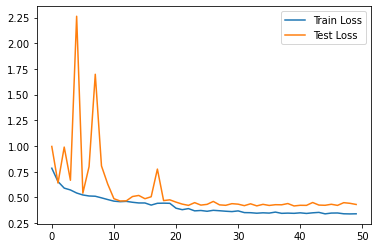

In [15]:
plt.plot(np.arange(len(train_losses)), train_losses, label='Train Loss')
plt.plot(np.arange(len(test_losses)), test_losses, label='Test Loss')
plt.legend(loc='best')
plt.show()

Accuracy도 확인합니다.

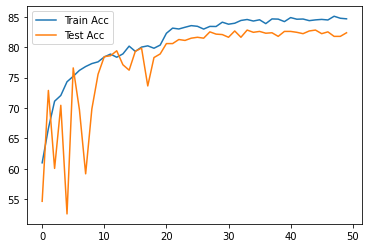

In [16]:
plt.plot(np.arange(len(train_accuracy)), train_accuracy, label='Train Acc')
plt.plot(np.arange(len(test_accuracy)), test_accuracy, label='Test Acc')
plt.legend(loc='best')
plt.show()

### 3-2-6. Predict

학습된 모델의 성능을 Test set을 통해 확인합니다.

먼저, Validation Loss가 가장 작았을 때의 모델의 Parameter를 불러옵니다.

In [9]:
checkpoint = torch.load('./best.pt')

model = ResNet18(num_classes=3).to(device)
model.load_state_dict(checkpoint)

<All keys matched successfully>

Test set을 불러오고 DataLoader를 만들어줍니다.

In [10]:
test = pd.read_pickle('./test.pkl')

dataset = ImageDataSet(test.image, test.label, train=False)
loader = DataLoader(dataset, batch_size=1, sampler=SequentialSampler(dataset))

모델을 통해 Test set의 라벨을 예측합니다.

In [11]:
predict = []
target = []

model.eval()

with torch.no_grad():
    for data, label in loader:
        data = data.to(device)

        output = model(data)

        target.append(label.numpy()[0])
        predict.append(torch.argmax(output, 1).cpu().numpy()[0])

Confusion Matrix를 활용해 예측 결과를 확인합니다.

비교적 간단한 모델인 ResNet18과 적은 수의 데이터로도 

모든 라벨에서의 정확도가 90%가 넘었으며, 전체 정확도가 약 93%가 나왔습니다. 

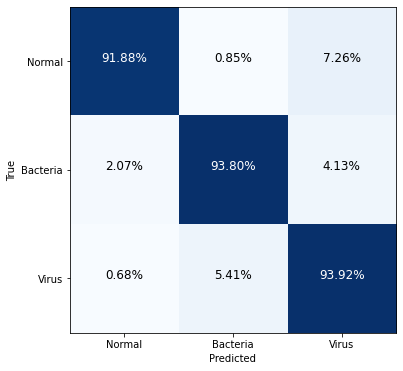

In [14]:
from sklearn.metrics import confusion_matrix
import itertools

target_names = ['Normal', 'Bacteria', 'Virus']

cm = confusion_matrix(target, predict, normalize='true')
plt.figure(figsize=(6, 6))
plt.xlabel('Predicted')
plt.xticks(np.arange(3), target_names)
plt.ylabel('True')
plt.yticks(np.arange(3), target_names)
plt.imshow(cm, cmap=plt.cm.Blues)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:.2f}%".format(cm[i, j] * 100), fontsize=12, horizontalalignment="center", color="white" if cm[i, j] >= 0.7 else "black")

plt.show()

Accuracy 등의 평가 지표를 확인합니다.

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print('Accuracy:   {:.4f}'.format(accuracy_score(y_pred=predict, y_true=target)))
print('Precision:  {:.4f}'.format(precision_score(y_pred=predict, y_true=target, average='micro')))
print('Recall:     {:.4f}'.format(recall_score(y_pred=predict, y_true=target, average='micro')))
print('F1 Score:   {:.4f}'.format(f1_score(y_pred=predict, y_true=target, average='micro')))

Accuracy:   0.9311
Precision:  0.9311
Recall:     0.9311
F1 Score:   0.9311
